# Fake News Detection — TF-IDF + LogisticRegression & LSTM
**Dataset:** Fake.csv & True.csv (Kaggle)  
**Environment:** Google Colab


(Code) Upload dataset files (quick, manual)

In [ ]:
from google.colab import files
uploaded = files.upload()   # click Choose Files → select Fake.csv and True.csv
# After upload, filenames are available as keys in `uploaded`


Saving archive (3).zip to archive (3).zip


In [ ]:
!ls


'archive (3).zip'   sample_data


Step 2 — Extract the ZIP file

In [ ]:
import zipfile, os

zip_path = "archive (3).zip"   # exact file name with space
extract_path = "/content/fake_news_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.listdir(extract_path)


['Fake.csv', 'True.csv']

Step 3 — Load the data

In [ ]:
import pandas as pd

fake = pd.read_csv(f"{extract_path}/Fake.csv")
true = pd.read_csv(f"{extract_path}/True.csv")

fake["label"] = 0
true["label"] = 1

df = pd.concat([fake[['title','text','label']], true[['title','text','label']]], ignore_index=True)


Step 4 — Combine title + text into one content column

In [ ]:
df["content"] = df["title"].fillna('') + ". " + df["text"].fillna('')
df = df[["content","label"]].sample(frac=1, random_state=42).reset_index(drop=True)
print(df.shape)
df.head()


(44898, 2)


,content,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,0
1,Trump drops Steve Bannon from National Securit...,1
2,Puerto Rico expects U.S. to lift Jones Act shi...,1
3,OOPS: Trump Just Accidentally Confirmed He Le...,0
4,Donald Trump heads for Scotland to reopen a go...,1


Text Preprocessing (Cleaning the content)

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove punctuation/numbers
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['clean_content'] = df['content'].apply(clean_text)
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,content,label,clean_content
0,Ben Stein Calls Out 9th Circuit Court: Committ...,0,ben stein calls th circuit court committed cou...
1,Trump drops Steve Bannon from National Securit...,1,trump drops steve bannon national security cou...
2,Puerto Rico expects U.S. to lift Jones Act shi...,1,puerto rico expects us lift jones act shipping...
3,OOPS: Trump Just Accidentally Confirmed He Le...,0,oops trump accidentally confirmed leaked israe...
4,Donald Trump heads for Scotland to reopen a go...,1,donald trump heads scotland reopen golf resort...


Split Data into Train and Test Sets

We’ll split 80% for training and 20% for testing.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['clean_content'], df['label'], test_size=0.2, random_state=42
)


Convert Text to Vectors (TF-IDF)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


Build a Deep Learning Model (LSTM or Dense Neural Net)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     2,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,692,097 (10.27 MB)

 Trainable params: 2,692,097 (10.27 MB)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [ ]:
history = model.fit(
    X_train_tfidf.toarray(), y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2
)


Epoch 1/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - accuracy: 0.9218 - loss: 0.1695 - val_accuracy: 0.9894 - val_loss: 0.0325
Epoch 2/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.9968 - loss: 0.0101 - val_accuracy: 0.9891 - val_loss: 0.0353
Epoch 3/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - accuracy: 0.9989 - loss: 0.0031 - val_accuracy: 0.9898 - val_loss: 0.0460
Epoch 4/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 43s 96ms/step - accuracy: 1.0000 - loss: 4.5154e-04 - val_accuracy: 0.9900 - val_loss: 0.0522
Epoch 5/5
449/449 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.9998 - loss: 7.8962e-04 - val_accuracy: 0.9898 - val_loss: 0.0528


Evaluate on Test Set

In [ ]:
loss, acc = model.evaluate(X_test_tfidf.toarray(), y_test)
print(f"Test Accuracy: {acc*100:.2f}%")


281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9919 - loss: 0.0422
Test Accuracy: 99.05%


Visualize Accuracy and Loss (optional)

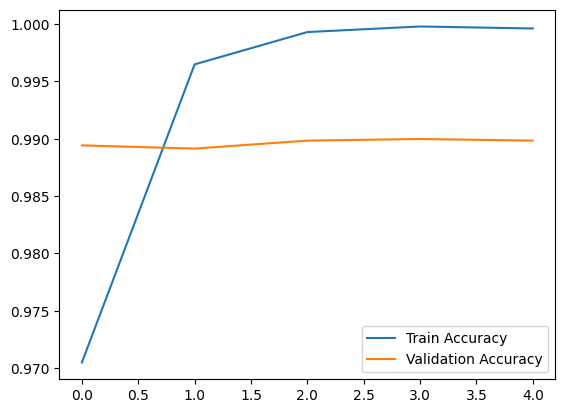

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


Save the Model and TF-IDF Vectorizer

In [ ]:
import joblib

# Save model
model.save("fake_news_model.h5")

# Save TF-IDF vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("✅ Model and vectorizer saved successfully!")


✅ Model and vectorizer saved successfully!


In [ ]:
from google.colab import files
files.download("fake_news_model.h5")
files.download("tfidf_vectorizer.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Load the Model and Vectorizer Later (optional)

In [ ]:
from tensorflow.keras.models import load_model
import joblib

model = load_model("fake_news_model.h5")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

print("✅ Model and vectorizer loaded successfully!")


✅ Model and vectorizer loaded successfully!


Test on New, Unseen News Articles

In [ ]:
def predict_news(news_text):
    cleaned = clean_text(news_text)
    vectorized = vectorizer.transform([cleaned])
    prediction = model.predict(vectorized.toarray())[0][0]
    if prediction > 0.5:
        print("🟢 This news seems REAL.")
    else:
        print("🔴 This news seems FAKE.")

# Example test
predict_news("Breaking: Scientists discover a new planet similar to Earth!")
predict_news("Donald Trump caught in scandal involving aliens on Mars!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
🔴 This news seems FAKE.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
🔴 This news seems FAKE.


Check Model Performance Metrics

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = (model.predict(X_test_tfidf.toarray()) > 0.5).astype("int32")

print(classification_report(y_test, y_pred))


281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4710
           1       0.99      0.99      0.99      4270

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



Distribution of Real vs Fake News

/tmp/ipython-input-3945229580.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='Set2')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128240 (\N{NEWSPAPER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


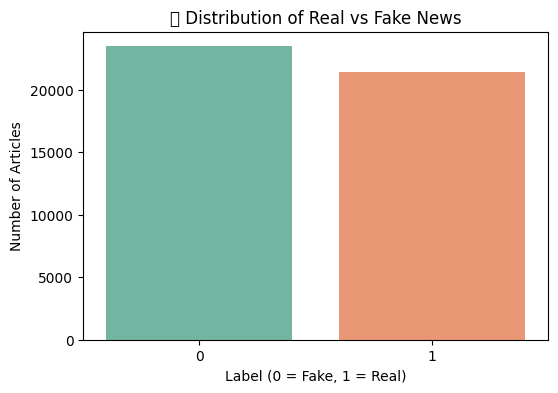

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label', palette='Set2')
plt.title("📰 Distribution of Real vs Fake News")
plt.xlabel("Label (0 = Fake, 1 = Real)")
plt.ylabel("Number of Articles")
plt.show()


Most Common Words in Fake News

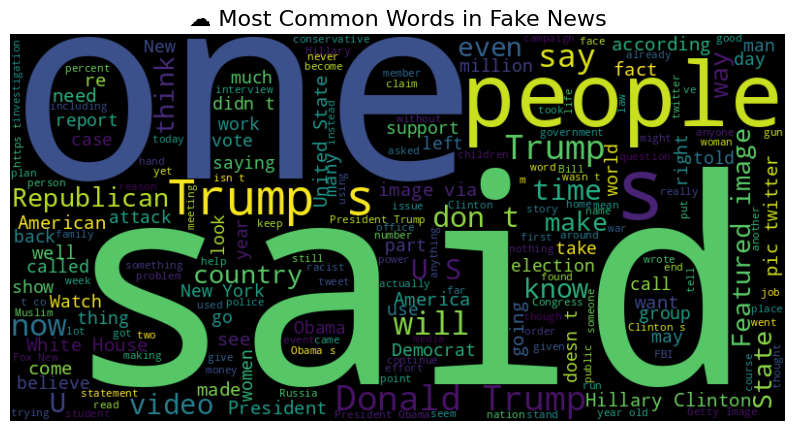

In [ ]:
from wordcloud import WordCloud

fake_texts = " ".join(df[df['label'] == 0]['content'])
wordcloud_fake = WordCloud(width=800, height=400, background_color='black').generate(fake_texts)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title("☁️ Most Common Words in Fake News", fontsize=16)
plt.show()


Most common word in true news

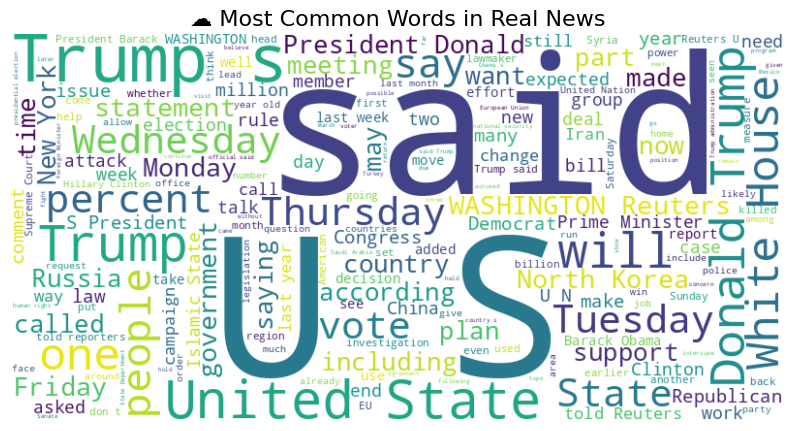

In [ ]:
real_texts = " ".join(df[df['label'] == 1]['content'])
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_texts)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title("☁️ Most Common Words in Real News", fontsize=16)
plt.show()
